In [1]:
import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)

In [3]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,0.612102,2.072624,dummy_constant,0.612102,2.072624,3.682188,2.485713,"[1, 2, 3]",False,
2,2.933850,2.597329,dummy_constant,2.933850,2.597329,14.297246,10.322412,"[1, 2, 3]",False,
3,2.640082,2.677072,dummy_constant,2.640082,2.677072,13.037368,9.319595,"[1, 2, 3]",False,
4,1.628919,2.652372,dummy_constant,1.628919,2.652372,8.770261,5.907165,"[1, 2, 3]",False,
5,0.304504,2.137183,dummy_constant,0.304504,2.137183,3.724206,2.718586,"[1, 2, 3]",False,
6,0.273495,2.124956,dummy_constant,0.273495,2.124956,3.636170,2.691786,"[1, 2, 3]",False,
7,0.722903,2.296126,dummy_constant,0.722903,2.296126,4.778082,3.275754,"[1, 2, 3]",False,
8,1.278713,2.949986,dummy_constant,1.278713,2.949986,9.240911,6.608823,"[1, 2, 3]",False,
9,2.337044,1.532332,dummy_constant,2.337044,1.532332,6.908849,4.440440,"[1, 2, 3]",False,
10,1.791034,1.483642,dummy_constant,1.791034,1.483642,4.401673,2.634319,"[1, 2, 3]",False,


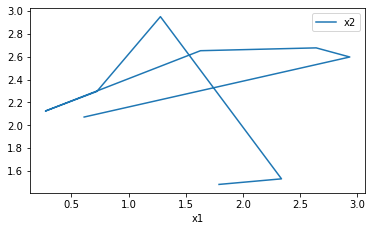

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


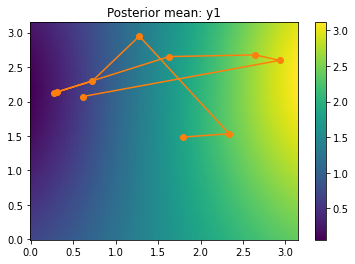

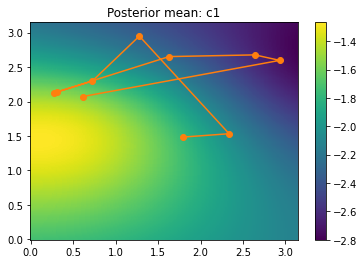

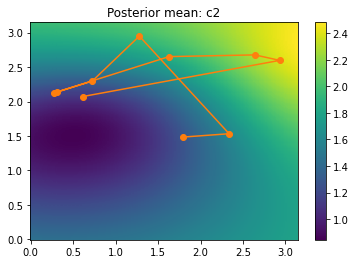

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

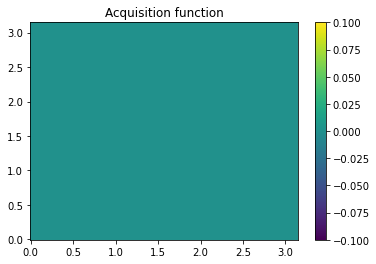

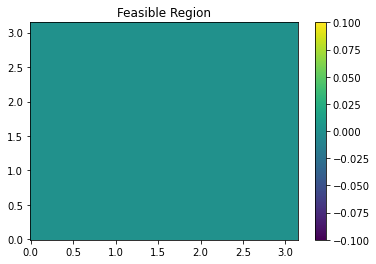

In [7]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")